In [1]:
%pip install slangtorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch
import slangtorch
import random

In [65]:
m = slangtorch.loadModule("render.slang")

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [6]:
def grid_size(shape, threads_dim = 16):
    return ((shape[0] + threads_dim - 1)//threads_dim, (shape[1] + threads_dim - 1)//threads_dim, 1)


In [59]:
import json

with open('scene_sample.json', 'r') as f:
    data = f.read()
    cfg = json.loads(data)

# cfg['cameras'][0]['pos']=[0, 2, 10]
# cfg['cameras'][0]['look_at']=[0, 1, 0]

In [52]:
block_size = (16, 16, 1)
shap = (cfg['render_width'], cfg['render_height'])
grid_size2 = grid_size(shap)

In [53]:
for obj in cfg['geometry']:
  print(obj)

{'type': 'plane', 'point': [0.0, -2.0, 0.0], 'normal': [0.0, 1.0, 0.0], 'material_id': 0}
{'type': 'sphere', 'center_radius': [0.0, 1.5, 0.0, 2.0], 'material_id': 2}
{'type': 'sphere', 'center_radius': [1.0, -1.0, 1.0, 1.0], 'material_id': 1}
{'type': 'sphere', 'center_radius': [-1.0, -1.0, 1.0, 1.0], 'material_id': 3}
{'type': 'sphere', 'center_radius': [-1.0, -1.0, -1.0, 1.0], 'material_id': 4}
{'type': 'sphere', 'center_radius': [-1.0, -1.0, -1.0, 1.0], 'material_id': 5}
{'type': 'sphere', 'center_radius': [5.0, 4.0, -1.0, 2.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [-5.0, 4.0, -1.0, 2.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [3.0, 2.0, 4.0, 1.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [-3.0, 2.0, 4.0, 1.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [3.0, 2.0, -2.0, 1.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [-3.0, 2.0, -2.0, 1.0], 'material_id': 6}


In [60]:
def prepare_scene_objects(json_config):
    geometry = json_config["geometry"]
    num_objects = len(geometry)

    # структура: [type, data0(x,y,z,w), data1(x,y,z,w), material_id]
    sdf_array = np.zeros((num_objects, 10), dtype=np.float32)

    for i, obj in enumerate(geometry):
        if obj["type"] == "sphere":
            sdf_array[i, 0] = 1  # type: sphere
            sdf_array[i, 1:5] = obj["center_radius"]
            sdf_array[i, 9] = obj["material_id"]
        elif obj["type"] == "plane":
            sdf_array[i, 0] = 0  # type: plane
            sdf_array[i, 1:4] = obj["point"]
            sdf_array[i, 5:8] = obj["normal"]
            sdf_array[i, 9] = obj["material_id"]
        else:
            raise ValueError(f"Unknown geometry type: {obj['type']}")

    sdf_tensor = torch.tensor(sdf_array, dtype=torch.float32).cuda()
    return sdf_tensor, num_objects

def prepare_camera_struct(config):
    cam = config["cameras"][0]
    pos = cam["pos"]
    look = cam["look_at"]
    up = cam["up"]
    params = (*pos, *look, *up)
    return params



In [61]:
prepare_scene_objects(cfg)

(tensor([[ 0.0000,  0.0000, -2.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.5000,  0.0000,  2.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  2.0000],
         [ 1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  1.0000],
         [ 1.0000, -1.0000, -1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  3.0000],
         [ 1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  4.0000],
         [ 1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  5.0000],
         [ 1.0000,  5.0000,  4.0000, -1.0000,  2.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  6.0000],
         [ 1.0000, -5.0000,  4.0000, -1.0000,  2.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  6.0000],
         [ 1.0000,  3.0000,  2.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  6.0000],
 

In [66]:
scene_tensor, obj_count = prepare_scene_objects(cfg)

output = torch.zeros((cfg["render_width"], cfg["render_height"], 3), dtype=torch.float32).cuda()

m.render(
    output=output,
    objects=scene_tensor,
    obj_count=obj_count,
    inp_camera_params=prepare_camera_struct(cfg)
).launchRaw(blockSize=block_size, gridSize=grid_size2)

In [67]:
 cam_params=prepare_camera_struct(cfg)
 cam_params

(0, 4, 10, 0, 0, -1, 0, 1, 0)

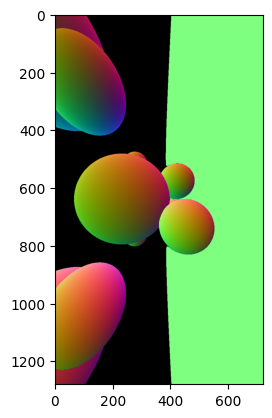

In [68]:
plt.imshow(output.cpu())

In [49]:
print("pos", cfg["cameras"][0]["pos"])
print("look_at", cfg["cameras"][0]["look_at"])

pos [0, 4, 10]
look_at [0, 0, -1]
